# Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit
import time
from torch.optim import Adam
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt, random
import sklearn
from scipy.stats import loguniform
from sklearn.svm import SVR
from joblib import dump, load
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

2022-03-09 17:49:50.715042: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-09 17:49:50.715060: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [19]:
all_times = []
le_times = []
g_times = []

pred_all_times = []
pred_le_times = []
pred_g_times = []

all_MAE = []
le_MAE = []
g_MAE = []

# Data

In [56]:
num_data = "100k"

In [57]:
df = pd.read_csv("train/{}.csv".format(num_data))
df.drop(["c/b", "F"], axis=1, inplace=True)
d = df.to_numpy()

d_le = np.load("train/{}_le1.npy".format(num_data))
d_g = np.load("train/{}_g1.npy".format(num_data))

d.shape, d_le.shape, d_g.shape

((97290, 4), (44390, 4), (52900, 4))

# Hyperparameter Optimisation

In [143]:
# defining parameter range
param_grid = {'C': list(10. ** np.arange(-3, 8)),
              'gamma': list(10. ** np.arange(-5, 4)),
              'kernel': ['rbf']}
 
# define search
grid = RandomizedSearchCV(SVR(), param_grid, n_iter=50, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
# fitting the model for grid search
grid.fit(d[:,:3], d[:,3])

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ...................C=100.0, gamma=0.001, kernel=rbf; total time=   9.7s
[CV] END .................C=1000.0, gamma=1000.0, kernel=rbf; total time= 1.9min
[CV] END .....................C=10.0, gamma=10.0, kernel=rbf; total time=   1.0s
[CV] END .....................C=10.0, gamma=10.0, kernel=rbf; total time=   1.8s
[CV] END .....................C=10.0, gamma=10.0, kernel=rbf; total time=   1.6s
[CV] END ...................C=100.0, gamma=1e-05, kernel=rbf; total time=   8.2s
[CV] END ...................C=100.0, gamma=1e-05, kernel=rbf; total time=  18.8s
[CV] END ..................C=0.001, gamma=1000.0, kernel=rbf; total time=  27.1s
[CV] END ....................C=0.1, gamma=1000.0, kernel=rbf; total time= 1.2min
[CV] END .......................C=1.0, gamma=0.1, kernel=rbf; total time=   0.7s
[CV] END .......................C=1.0, gamma=0.1, kernel=rbf; total time=   3.1s
[CV] END .......................C=1.0, gamma=0.

[CV] END ...................C=100.0, gamma=0.001, kernel=rbf; total time=   9.3s
[CV] END ....................C=1.0, gamma=1000.0, kernel=rbf; total time= 2.0min
[CV] END .....................C=10.0, gamma=10.0, kernel=rbf; total time=   1.7s
[CV] END .....................C=10.0, gamma=10.0, kernel=rbf; total time=   1.5s
[CV] END ...................C=100.0, gamma=1e-05, kernel=rbf; total time=  14.9s
[CV] END ..................C=0.001, gamma=1000.0, kernel=rbf; total time=  28.2s
[CV] END ....................C=0.1, gamma=1000.0, kernel=rbf; total time= 1.5min
[CV] END .................C=1000.0, gamma=0.0001, kernel=rbf; total time=  13.5s
[CV] END ....................C=10.0, gamma=1e-05, kernel=rbf; total time=  23.1s
[CV] END ....................C=1000.0, gamma=0.1, kernel=rbf; total time=   0.7s
[CV] END ....................C=1000.0, gamma=0.1, kernel=rbf; total time=   8.4s
[CV] END ......................C=10.0, gamma=1.0, kernel=rbf; total time=   0.2s
[CV] END ...................

RandomizedSearchCV(estimator=SVR(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1.0, 10.0,
                                              100.0, 1000.0, 10000.0, 100000.0,
                                              1000000.0, 10000000.0],
                                        'gamma': [1e-05, 0.0001, 0.001, 0.01,
                                                  0.1, 1.0, 10.0, 100.0,
                                                  1000.0],
                                        'kernel': ['rbf']},
                   scoring='neg_mean_squared_error', verbose=2)

In [144]:
#print best parameter after tuning
print(grid.best_params_)

{'kernel': 'rbf', 'gamma': 0.01, 'C': 10000.0}


# NN Fitting

For 12k: gamma=0.01, C=10000

For 25k: gamma=0.01, C=10000

For 50k: gamma=0.01, C=10000

For 100k: gamma=0.01, C=10000

In [58]:
t0 = time.time()
reg_all = SVR(kernel="rbf", gamma=0.01, C=10000)
reg_all.fit(d[:,:-1], d[:,-1])
t1 = time.time()
print("RBF train time: {} secs".format(t1-t0))

all_times.append(t1-t0)

RBF train time: 249.34028697013855 secs


In [59]:
# a/c > 1
t0 = time.time()
reg_g = SVR(kernel="rbf", gamma=0.01, C=10000)
reg_g.fit(d_g[:,:-1], d_g[:,-1])
t1 = time.time()
print("RBF train time: {} secs".format(t1-t0))

g_times.append(t1-t0)

RBF train time: 1.6381511688232422 secs


In [60]:
# a/c <= 1
t0 = time.time()
reg_le = SVR(kernel="rbf", gamma=0.01, C=10000)
reg_le.fit(d_le[:,:-1], d_le[:,-1])
t1 = time.time()
print("RBF train time: {} secs".format(t1-t0))

le_times.append(t1-t0)

RBF train time: 87.94084119796753 secs


# Results

In [61]:
df = pd.read_csv("test/2_RN_eqn_data_TEST.csv")
df.drop(["c/b", "F"], axis=1, inplace=True)
d = df.to_numpy()

d_le = np.load("test/le1.npy")
d_g = np.load("test/g1.npy")

d.shape, d_le.shape, d_g.shape

((13824, 4), (6336, 4), (7488, 4))

In [62]:
def error(reg, data):
    t0 = time.time()
    result = reg.predict(data[:,:-1])
    t1 = time.time()
    MAE = np.mean(np.abs(result-data[:,-1]))
    return MAE, t1-t0

mse, t = error(reg_all, d)
pred_all_times.append(t)
all_MAE.append(mse)
print("MAE all: ", mse)
print("Prediction time: ", t)

mse_le, t = error(reg_le, d)
pred_le_times.append(t)
le_MAE.append(mse)
print("MAE a/c<=1: ", mse_le)
print("Prediction time: ", t)

mse_g, t = error(reg_g, d)
pred_g_times.append(t)
g_MAE.append(mse)
print("MAE a/c>1: ", mse_g)
print("Prediction time: ", t)

MAE all:  0.041619695291066884
Prediction time:  0.7709693908691406
MAE a/c<=1:  0.4531641616245748
Prediction time:  0.4461655616760254
MAE a/c>1:  0.07889816512198362
Prediction time:  0.011432886123657227


In [63]:
dump(reg_all, "models/{}_RBF_all.joblib".format(num_data))
dump(reg_le, "models/{}_RBF_le.joblib".format(num_data))
dump(reg_g, "models/{}_RBF_g.joblib".format(num_data))

['models/100k_RBF_g.joblib']

## Fitting Equation

In [64]:
def sort(data):
    models = []
    model = np.unique(data[:,[0,1,2]], axis=0)
    
    for i in model:
        models.append(data[np.where((data[:,[0,1,2]] == i).all(axis=1))])

    return models 

def compare(model):
    results_all = []
    results_sep = []
    
    result = np.zeros((len(model),1))
    model = np.delete(model, [2,4], 1)

    result[:,0] = reg_all.predict(model[:,:-1])
    results_all.append(result)

    # a/c separated
    result = np.zeros((len(model),1))
    if model[0,0] <= 1:
        result[:,0] = reg_le.predict(model[:,:-1])

    elif model[0,0] > 1:
        result[:,0] = reg_g.predict(model[:,:-1])

    else:
        print("Something wrong!")

    results_sep.append(result)
        
    return results_all, results_sep



def plot(model_num):
    results_all, results_sep = compare(models[model_num])
    plt.scatter(models[model_num][:,-3], models[model_num][:,-1], label="Ground Truth")
    plt.plot(models[model_num][:,-3], results_all[0][:,0], label="RBF all", color='red')
    plt.plot(models[model_num][:,-3], results_sep[0][:,0], label="RBF separated", color='green')
    plt.title("a/c={}; a/t={}; c/b={}".format(models[model_num][0,0],
                                             models[model_num][0,1],
                                             models[model_num][0,2]))
    plt.xlabel("phi")
    plt.ylabel("Mg")
    plt.legend()
    plt.show()
    return

In [65]:
# Loading test dataset
df = pd.read_csv("test/2_RN_eqn_data_TEST.csv")
d = df.to_numpy()
d.shape

(13824, 6)

In [66]:
models = sort(d)
len(models)

576

In [67]:
interact(plot, model_num=(1,len(models)-1,1));

interactive(children=(IntSlider(value=288, description='model_num', max=575, min=1), Output()), _dom_classes=(…

In [68]:
np.save("results/all_times.npy", all_times)
np.save("results/le_times.npy", le_times)
np.save("results/g_times.npy", g_times)

np.save("results/pred_all_times.npy", pred_all_times)
np.save("results/pred_le_times.npy", pred_le_times)
np.save("results/pred_g_times.npy", pred_g_times)

np.save("results/all_MAE.npy", all_MAE)
np.save("results/le_MAE.npy", le_MAE)
np.save("results/g_MAE.npy", g_MAE)

Text(0.5, 1.0, 'RBF Training Time')

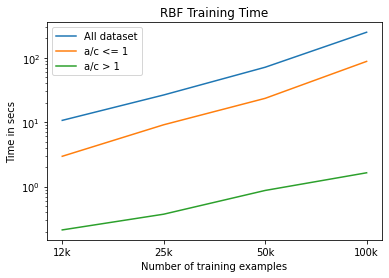

In [71]:
num_data = ["12k", "25k", "50k", "100k"]
plt.plot(num_data, all_times, label="All dataset")
plt.plot(num_data, le_times, label="a/c <= 1")
plt.plot(num_data, g_times, label="a/c > 1")
plt.legend()
plt.semilogy()
plt.xlabel("Number of training examples")
plt.ylabel("Time in secs")
plt.title("RBF Training Time")

Text(0.5, 1.0, 'RBF Testing Time')

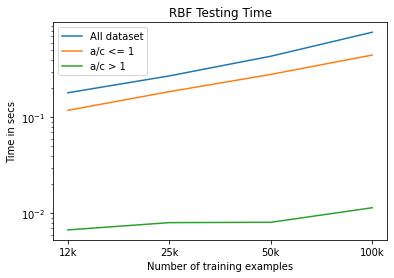

In [72]:
num_data = ["12k", "25k", "50k", "100k"]
plt.plot(num_data, pred_all_times, label="All dataset")
plt.plot(num_data, pred_le_times, label="a/c <= 1")
plt.plot(num_data, pred_g_times, label="a/c > 1")
plt.legend()
plt.semilogy()
plt.xlabel("Number of training examples")
plt.ylabel("Time in secs")
plt.title("RBF Testing Time")

Text(0.5, 1.0, 'RBF Mean Absolute Error')

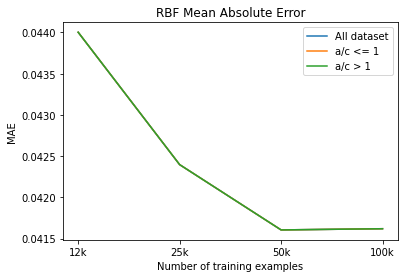

In [74]:
num_data = ["12k", "25k", "50k", "100k"]
plt.plot(num_data, all_MAE, label="All dataset")
plt.plot(num_data, le_MAE, label="a/c <= 1")
plt.plot(num_data, g_MAE, label="a/c > 1")
plt.legend()
plt.xlabel("Number of training examples")
plt.ylabel("MAE")
plt.title("RBF Mean Absolute Error")